In [15]:
import numpy as np
from scipy.special import expit  # 로지스틱 함수 (inverse logit)
from scipy.stats import bernoulli
import cmdstanpy
import os

In [16]:
# 저장 경로 설정 (현재 작업 디렉토리)
stan_file_path = "rasch_model.stan"

# Stan 모델 코드 정의
stan_code = """
data {
  int<lower=0> I; // people
  int<lower=1> J;             // difficulty
  array[I, J] int<lower=0, upper=1> y;  // 응답 행렬 (0:오답, 1:정답)
}

parameters {
  vector[I] theta;          // 학생 능력 (Estimated)
  vector[J] beta; // difficulty
}

model {

// prior
theta ~ normal(0, 1); // identifiability가 필요함. 왜? 능력 - 난도 0이면 1이던, 100이던 다 0이 되어서 '알 수 없음'이 되어버림
beta ~ normal(0, 1); // theta 혹은 beta 둘 중 하나는 꼭 필요함

for (i in 1:I) {
  for (j in 1:J) {
        y[i,j] ~ bernoulli_logit(theta[i] - beta[j]);
    }
  }
}

"""

# 파일로 저장
with open(stan_file_path, "w") as f:
    f.write(stan_code)

print(f"Stan 모델 파일 생성 완료: {stan_file_path}")

Stan 모델 파일 생성 완료: rasch_model.stan


In [ ]:
# 재현성을 위한 시드 설정
np.random.seed(42)

# 1. 기본 설정
N = 30   # 학생 수
J = 20   # 문항 수

# 2. 파라미터 생성 (Uniform -2 ~ 2)
theta_true = np.random.uniform(-3, 3, N)
beta_true = np.random.uniform(-3, 3, J)

y = np.zeros((N, J), dtype=int)

for n in range(N):
    for j in range(J):
        difference = theta_true[n] - beta_true[j]
        p = expit(difference)
        y[n, j] = bernoulli.rvs(p)

data = {
    'I':N, 
    'J':J, 
    'y':y}


In [ ]:
# 1. 모델 컴파일
model = CmdStanModel(stan_file=stan_file_path)
print("모델 컴파일 완료")

15:34:59 - cmdstanpy - INFO - compiling stan file /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_model.stan to exe file /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_model
15:35:16 - cmdstanpy - INFO - compiled model executable: /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_model
15:35:16 - cmdstanpy - INFO - Chain [1] start processing
15:35:16 - cmdstanpy - INFO - Chain [1] done processing


모델 컴파일 완료
CmdStanMLE: model=rasch_model['method=optimize']
 csv_file:
	/tmp/tmph7ch7nfq/rasch_modelnk3qg0xx/rasch_model-20251202153516.csv
 output_file:
	/tmp/tmph7ch7nfq/rasch_modelnk3qg0xx/rasch_model-20251202153516_0-stdout.txt


In [21]:
opt = model.optimize(data=data)
estimated_theta = opt.stan_variable('theta')
print(estimated_theta)

15:37:13 - cmdstanpy - INFO - Chain [1] start processing
15:37:13 - cmdstanpy - INFO - Chain [1] done processing


[-0.40124792  1.8589377   1.3328902   0.64497469 -1.5292839  -1.2829455
 -2.0839167   1.858936    0.43094342  0.221066   -1.0502305   1.8589125
  1.5865898  -0.61193504 -1.0502066  -0.61193258 -0.82752253  0.86508842
  0.01351448 -0.61193265  0.22104781 -0.40124805  0.22106995 -0.82748143
  0.01353983  1.0934998  -0.82748148  0.22106712  0.64501261 -1.7941021 ]


In [ ]:
# 3. 모델 적합 (추천: MCMC Sampling)
# optimize 대신 sample을 사용하는 것이 베이지안 분석에 더 적합합니다.
fit = model.sample(data=data, 
                   chains=4,           # 체인 수 (보통 4)
                   iter_warmup=1000,   # 워밍업 반복 수
                   iter_sampling=1000, # 실제 샘플링 수
                   show_progress=True)

print("모델 적합(Sampling) 완료")

# 4. 결과 확인
print(fit.summary().head()) # 결과 요약표 출력 (상위 5개)

# (참고) 만약 optimize를 꼭 써야 한다면 아래와 같이 결과를 꺼냅니다.


15:35:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:


15:35:48 - cmdstanpy - INFO - CmdStan done processing.



모델 적합(Sampling) 완료
                Mean      MCSE    StdDev       MAD          5%         50%  \
lp__     -299.013000  0.131150  5.150820  5.142810 -307.764000 -298.782000   
theta[1]   -0.414465  0.008056  0.484012  0.481600   -1.213310   -0.411362   
theta[2]    1.952960  0.008770  0.572141  0.582641    1.035580    1.940930   
theta[3]    1.411620  0.007965  0.522291  0.521176    0.567457    1.403410   
theta[4]    0.675063  0.007294  0.481897  0.475689   -0.103046    0.672078   

                 95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__     -291.082000   1517.02   2360.04     248.367  1.00167  
theta[1]    0.369606   3667.75   3067.74     600.483  1.00033  
theta[2]    2.910330   4314.68   2722.72     706.399  1.00069  
theta[3]    2.279590   4383.25   2914.77     717.624  1.00287  
theta[4]    1.457240   4431.03   2811.42     725.447  1.00178  


In [24]:
# 전체 요약표 가져오기
summary_df = fit.summary()

# 'theta'로 시작하는 파라미터만 필터링 (학생별 능력치)
theta_summary = summary_df[summary_df.index.str.startswith('theta')]

# 결과 출력 (Mean: 추정된 능력 평균, 5%~95%: 신뢰구간)
print(theta_summary[['Mean', 'StdDev', '5%', '95%']])

               Mean    StdDev        5%       95%
theta[1]  -0.414465  0.484012 -1.213310  0.369606
theta[2]   1.952960  0.572141  1.035580  2.910330
theta[3]   1.411620  0.522291  0.567457  2.279590
theta[4]   0.675063  0.481897 -0.103046  1.457240
theta[5]  -1.611200  0.529283 -2.483480 -0.752409
theta[6]  -1.363560  0.523364 -2.237820 -0.536415
theta[7]  -2.183100  0.563517 -3.126690 -1.300660
theta[8]   1.959120  0.559003  1.059190  2.916960
theta[9]   0.456098  0.496805 -0.370781  1.269760
theta[10]  0.242529  0.497236 -0.582818  1.070040
theta[11] -1.100560  0.492625 -1.892360 -0.302672
theta[12]  1.943280  0.568013  1.023990  2.858910
theta[13]  1.667130  0.545386  0.792478  2.588950
theta[14] -0.645102  0.491215 -1.462420  0.159483
theta[15] -1.098400  0.504040 -1.943340 -0.276441
theta[16] -0.651186  0.507773 -1.481540  0.204253
theta[17] -0.866939  0.515983 -1.713540 -0.017685
theta[18]  0.925177  0.503300  0.092315  1.748890
theta[19]  0.017023  0.474441 -0.751095  0.778841


/tmp/ipykernel_15797/193255682.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


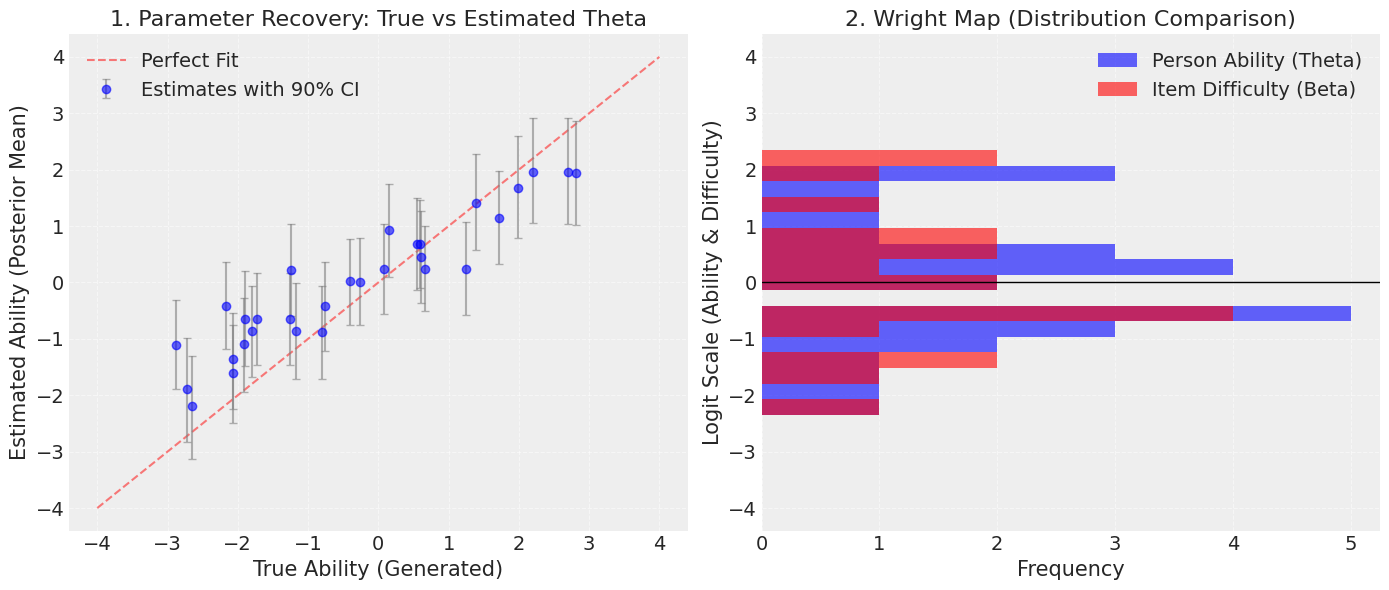

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. 데이터 추출 및 정리
summary = fit.summary()

# Theta (학생 능력) 통계
theta_df = summary[summary.index.str.startswith('theta')]
theta_est = theta_df['Mean'].values
theta_lower = theta_df['5%'].values
theta_upper = theta_df['95%'].values
theta_err = [theta_est - theta_lower, theta_upper - theta_est] # 에러바용

# Beta (문항 난이도) 통계 - Wright Map용
beta_df = summary[summary.index.str.startswith('beta')]
beta_est = beta_df['Mean'].values

# -------------------------------------------------------
# 시각화 1: Parameter Recovery (참값 vs 추정값)
# -------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# y=x 기준선 (Perfect Recovery)
plt.plot([-4, 4], [-4, 4], 'r--', alpha=0.5, label='Perfect Fit')

# 산점도 및 에러바 (신뢰구간 90%)
plt.errorbar(theta_true, theta_est, yerr=theta_err, fmt='o', 
             ecolor='gray', color='blue', alpha=0.6, capsize=3, label='Estimates with 90% CI')

plt.title('1. Parameter Recovery: True vs Estimated Theta')
plt.xlabel('True Ability (Generated)')
plt.ylabel('Estimated Ability (Posterior Mean)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# -------------------------------------------------------
# 시각화 2: Wright Map (Person-Item Map)
# -------------------------------------------------------
# 학생 능력 분포와 문항 난이도 분포를 같은 축(y축)에 그립니다.
plt.subplot(1, 2, 2)

# 공통 bins 설정
bins = np.linspace(-4, 4, 30)

# 학생 능력 히스토그램 (왼쪽)
plt.hist(theta_est, bins=bins, orientation='horizontal', alpha=0.6, 
         color='blue', label='Person Ability (Theta)')

# 문항 난이도 히스토그램 (오른쪽 - 겹쳐서 비교)
# 문항 난이도를 더 잘 보이게 하기 위해 투명도 조절 또는 별도 표시
plt.hist(beta_est, bins=bins, orientation='horizontal', alpha=0.6, 
         color='red', label='Item Difficulty (Beta)')

# 중심선 (0 logit)
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.title('2. Wright Map (Distribution Comparison)')
plt.xlabel('Frequency')
plt.ylabel('Logit Scale (Ability & Difficulty)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()